In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd.variable import Variable
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import imageio


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
torch.manual_seed(1)

In [5]:
import numpy as np
from matplotlib import pyplot as plt

In [6]:
transform = transforms.Compose([
                transforms.Resize((64, 64)),
                transforms.ToTensor(),
                transforms.Normalize((0.5,),(0.5,))
                ])
to_image = transforms.ToPILImage()
trainset = MNIST(root='./data/', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=100, shuffle=True)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [7]:
#showing images
def show_images(images):
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach(), nrow=22).permute(1, 2, 0))

def show_batch(dl):
    for images, _ in dl:
        show_images(images)
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


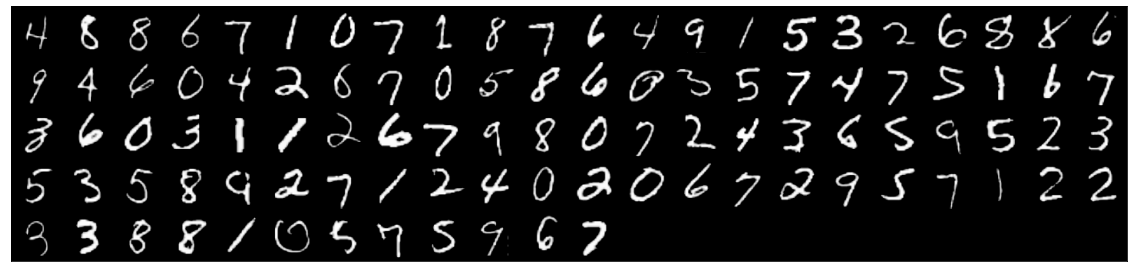

In [8]:
show_batch(trainloader)

In [9]:
latent_dim = 128

In [10]:
# Generator Model Class Definition      
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Block 1:input is Z, going into a convolution
            nn.ConvTranspose2d(latent_dim, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            # Block 2: (64 * 8) x 4 x 4
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            # Block 3: (64 * 4) x 8 x 8
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            # Block 4: (64 * 2) x 16 x 16
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # Block 5: (64) x 32 x 32
            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
            nn.Tanh()
            # Output: (3) x 64 x 64
        )

    def forward(self, input):
        output = self.main(input)
        return output 

In [11]:
# Discriminator Model Class Definition
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Block 1: (3) x 64 x 64
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 2: (64) x 32 x 32
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 3: (64*2) x 16 x 16
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 4: (64*4) x 8 x 8
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 5: (64*8) x 4 x 4
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
            nn.Flatten()
            # Output: 1
        )

    def forward(self, input):
        output = self.main(input)
        return output

In [12]:
# custom weights initialization called on gen and disc model
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias) 

In [13]:
generator = Generator().to(device)
print(generator.apply(weights_init))

discriminator = Discriminator().to(device)
print(discriminator.apply(weights_init))

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [14]:
#hyperparameters 
g_optim = optim.Adam(generator.parameters(), lr=2e-4)
d_optim = optim.Adam(discriminator.parameters(), lr=2e-4)

g_losses = []
d_losses = []
images = []

criterion = nn.BCELoss()

def noise(n, n_features=128):
    return Variable(torch.randn(n, n_features,1,1)).to(device)

def make_ones(size):
    data = Variable(torch.ones(size, 1))
    return data.to(device)

def make_zeros(size):
    data = Variable(torch.zeros(size, 1))
    return data.to(device)

In [21]:
def train_discriminator(optimizer, real_data, fake_data):
    n = real_data.size(0)

    optimizer.zero_grad()
    
    prediction_real = discriminator(real_data)
    error_real = criterion(prediction_real, make_ones(n))
    error_real.backward()

    prediction_fake = discriminator(fake_data)
    error_fake = criterion(prediction_fake, make_zeros(n))
    
    error_fake.backward()
    optimizer.step()
    
    return error_real + error_fake

def train_generator(optimizer, fake_data):
    n = fake_data.size(0)
    optimizer.zero_grad()
    
    prediction = discriminator(fake_data)
    error = criterion(prediction, make_ones(n))
    
    error.backward()
    optimizer.step()
    
    return error


In [22]:
num_epochs = 50
k = 1
test_noise = noise(1)

generator.train()
discriminator.train()
for epoch in range(num_epochs):
    g_error = 0.0
    d_error = 0.0
    for i, data in enumerate(trainloader):
        imgs, _ = data
        n = len(imgs)
        for j in range(k):
            noise_vector = noise(imgs.size(0))  
            fake_data = generator(noise_vector).detach()
            real_data = imgs.to(device)
            d_error += train_discriminator(d_optim, real_data, fake_data)
        fake_data = generator(noise_vector)
        g_error += train_generator(g_optim, fake_data)

    img = generator(test_noise)
    img = make_grid(img.cpu().detach())
    images.append(img)
    g_losses.append(g_error/i)
    d_losses.append(d_error/i)
    print('Epoch {}: g_loss: {:.8f} d_loss: {:.8f}\r'.format(epoch, g_error/i, d_error/i))

    torch.save({
    'epochs': epoch,
    'generator_model_state_dict': generator.state_dict(),
    'discriminator_model_state_dict': discriminator.state_dict(),
    'g_loss': g_losses,
    'd_loss': d_losses,
    'img':images,
}, '/content/gdrive/MyDrive/Colab Notebooks/ComputerVision/DCGAN_model.pt_'+str(epoch))
    
print('Training Finished')
# torch.save(generator.state_dict(), 'mnist_generatorDCGAN.pth')




Epoch 0: g_loss: 9.04870605 d_loss: 0.09944312
Epoch 1: g_loss: 6.99323893 d_loss: 0.09588604
Epoch 2: g_loss: 6.31393433 d_loss: 0.09085882
Epoch 3: g_loss: 6.04661989 d_loss: 0.13635151
Epoch 4: g_loss: 5.21321535 d_loss: 0.20105188
Epoch 5: g_loss: 5.58668137 d_loss: 0.20803367
Epoch 6: g_loss: 5.13253975 d_loss: 0.23125517
Epoch 7: g_loss: 5.34423923 d_loss: 0.22047971
Epoch 8: g_loss: 5.24392223 d_loss: 0.19090839
Epoch 9: g_loss: 5.34539747 d_loss: 0.18055524
Epoch 10: g_loss: 5.31544590 d_loss: 0.20571917
Epoch 11: g_loss: 5.17723846 d_loss: 0.19113733
Epoch 12: g_loss: 5.61095381 d_loss: 0.20700388
Epoch 13: g_loss: 5.29216719 d_loss: 0.15305597
Epoch 14: g_loss: 5.74608326 d_loss: 0.19717398
Epoch 15: g_loss: 5.36352158 d_loss: 0.11975279
Epoch 16: g_loss: 10.29341221 d_loss: 0.00367268
Epoch 17: g_loss: 8.89592743 d_loss: 0.00278233
Epoch 18: g_loss: 8.75172424 d_loss: 0.00236045
Epoch 19: g_loss: 9.38309765 d_loss: 0.00145506
Epoch 20: g_loss: 10.56427860 d_loss: 0.00141346


In [62]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

checkpoint = torch.load('/content/gdrive/MyDrive/Colab Notebooks/ComputerVision/DCGAN_model.pt_15')
generator.load_state_dict(checkpoint['generator_model_state_dict'])
discriminator.load_state_dict(checkpoint['discriminator_model_state_dict'])

g_losses = checkpoint['g_loss']
d_losses = checkpoint['d_loss']


In [63]:
# print(generator.state_dict())
# print(discriminator.state_dict())

In [76]:
#saving progress image
import numpy as np
from matplotlib import pyplot as plt
imgs = [np.array(to_image(i)) for i in images]
imageio.mimsave('progressDCGAN.gif', imgs)

In [65]:
#converting to tensor
print(type(g_losses))
g_losses_T = torch.tensor(g_losses)
print(type(g_losses_T))

print(type(d_losses))
d_losses_T = torch.tensor(d_losses)
print(type(d_losses_T))

<class 'list'>
<class 'torch.Tensor'>
<class 'list'>
<class 'torch.Tensor'>


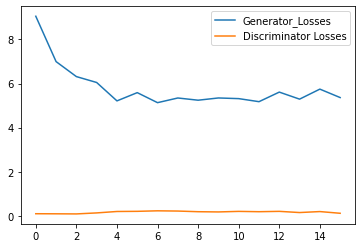

In [66]:
#plotting loss
plt.plot(g_losses_T, label='Generator_Losses')
plt.plot(d_losses_T, label='Discriminator Losses')
plt.legend()
plt.savefig('lossDCGAN.png')

Descriminator loss decreased till 15th epoch and it starts increasing

Generator loss increased till 15th epoch and it become constant

Hence optimum number of epchoes is 15 without model over filtting

In [67]:
#printing loss values
print(g_losses[0])
print(g_losses[-1])

print(d_losses[0])
print(d_losses[-1])

tensor(9.0487, device='cuda:0', requires_grad=True)
tensor(5.3635, device='cuda:0', requires_grad=True)
tensor(0.0994, device='cuda:0', requires_grad=True)
tensor(0.1198, device='cuda:0', requires_grad=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>
torch.Size([3, 64, 64])


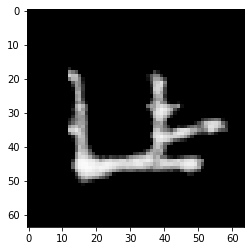

In [75]:
#ploting image
print(type(images[-1]))
print(images[-1].shape)
plt.imshow(images[21].T)

In [69]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((64,64)), cmap='Greys_r')

In [70]:
# randomly generated, new latent vectors
sample_size=16
rand_z = noise(sample_size)
# rand_z = rand_z.cpu().detach()

generator.eval()# eval mode
# generated samples
rand_images = generator(rand_z)
rand_images_T = rand_images.cpu().detach()
print(type(rand_images_T))

<class 'torch.Tensor'>


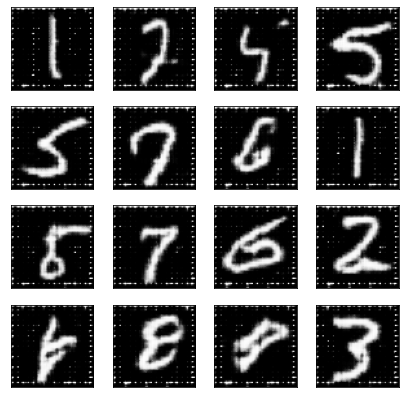

In [71]:
view_samples(-1, [rand_images_T])

References:
https://learnopencv.com/deep-convolutional-gan-in-pytorch-and-tensorflow/

https://learnopencv.com/conditional-gan-cgan-in-pytorch-and-tensorflow/

https://learnopencv.com/introduction-to-generative-adversarial-networks/

https://github.com/safwankdb/Vanilla-GAN

https://github.com/tooth2/Handwritten-digits-generation/blob/main/MNIST_GAN.ipynb